# オッズの予測精度評価
人気順の上位3位が、実際に3位以内に入る可能性のモデルの精度評価。このスコアを超えない限り、オッズ通りに買った方が有利ということになる。

In [1]:
# Resultモデルをデータフレームに変換
import pandas as pd
from datetime import date
ext_dt = date(2015,1,1)
results = Result.objects.filter(race__race_dt__gte=ext_dt, race__result_flg=True).exclude(rank=0).values("rank", "odor")
df = pd.DataFrame.from_records(results)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158423 entries, 0 to 158422
Data columns (total 2 columns):
odor    158423 non-null int64
rank    158280 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.4 MB


In [2]:
import numpy as np

# 目的変数の作成（3位以内ならゼロ、それ以外は1）
df["top3"] = np.where(df["rank"]<=3, 0, 1)
df["odor3"] = np.where(df["odor"]<=3, 0, 1)

# 不要データの削除
df = df.drop("rank", axis=1)
df = df.drop("odor", axis=1)

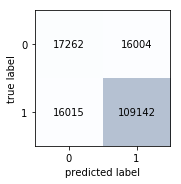

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Confusion Matrixを使った精度評価
cnf_matrix = confusion_matrix(df.top3, df.odor3)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

In [6]:
# モデルの評価指標
from sklearn.metrics import confusion_matrix
tp, fn, fp, tn = confusion_matrix(df.top3, df.odor3).ravel()

# Recall（検出率）
recall = round(tp / (tp + fn), 3)
print("１．複勝馬の的中率："+str(recall))

# Precision（精度）
precision = round(tp / (tp + fp), 3)
print("２．購入馬券の的中率："+str(precision))

１．複勝馬の的中率：0.519
２．購入馬券の的中率：0.519


# Sample Prediction Model Creation

## Table List
#### Race
| Column Name | Description          |
|:------------|:---------------------|
| race_id     | id field             |
| race_dt     | opening date of race |
| place_id    | race place id        |
| place_name  | race place name      |
| days        | race days            |
| times       | race times           |
| round       | race round           |
| title       | race title           |
| grade       | race grade           |
| type        | opening date of race |
| length      | opening date of race |
| weather     | opening date of race |
| condition   | opening date of race |
| head_count  | opening date of race |
| max_prize   | opening date of race |
| odds_stdev  | opening date of race |
| result_flg  | opening date of race |

In [2]:
# レース結果（2017年1月1日以降で出走結果のあるデータを抽出）
from datetime import date
import pandas as pd
ext_dt = date(2017,1,1)
results = Result.objects.filter(race__race_dt__gte=ext_dt, race__result_flg=True).exclude(rank=0).values("key", "rank", "sex", "age", "odds", "horse_id", "jockey_id", "race__race_dt", "race__max_prize", "race__head_count", "race__odds_stdev", "race__condition")
df = pd.DataFrame.from_records(results)

# データフレームの整形
df = df.set_index("key")
df = df.rename(columns={"race__race_dt": "race_dt", "race__max_prize": "race_prize", "race__head_count": "head_count", "race__odds_stdev": "odds_stdev", "race__condition": "condition"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61246 entries, 3回中山2日目 1R-2015102578 to 6回中山3日目 1R-2015101670
Data columns (total 11 columns):
age           61246 non-null int64
horse_id      61246 non-null object
jockey_id     61246 non-null object
odds          61246 non-null float64
condition     61246 non-null object
head_count    61246 non-null int64
race_prize    61246 non-null float64
odds_stdev    61246 non-null float64
race_dt       61246 non-null object
rank          61103 non-null float64
sex           61246 non-null object
dtypes: float64(4), int64(2), object(5)
memory usage: 5.6+ MB


In [3]:
# 出走回数と競走馬の複勝率の計算
def cal_run(hid, rdt):
    query = Result.objects.filter(horse_id=hid, race__race_dt__lt=rdt).exclude(rank=0)
    run_all = query.count()
    run_t3 = query.filter(rank__lte=3).count()
    
    ratio = round(run_t3 / run_all, 2) if run_all != 0 else 0
    return pd.Series([run_all, ratio])


df[["run_count", "t3_ratio"]] = df.apply(lambda row: cal_run(row["horse_id"], row["race_dt"]), axis=1)
df.head()

,age,horse_id,jockey_id,odds,condition,head_count,race_prize,odds_stdev,race_dt,rank,sex,run_count,t3_ratio
key,,,,,,,,,,,,,
3回中山2日目 1R-2015102578,3,2015102578,01095,8.9,稍重,16,500.0,81.29,2018-03-03,1.0,牝,3.0,0.33
3回中山2日目 1R-2015103403,3,2015103403,01004,187.6,稍重,16,500.0,81.29,2018-03-03,2.0,牝,5.0,0.00
3回中山2日目 1R-2015100599,3,2015100599,01122,5.3,稍重,16,500.0,81.29,2018-03-03,3.0,牝,3.0,0.00
3回中山2日目 1R-2015105711,3,2015105711,01085,4.8,稍重,16,500.0,81.29,2018-03-03,4.0,牝,5.0,0.00
3回中山2日目 1R-2015106131,3,2015106131,01169,3.5,稍重,16,500.0,81.29,2018-03-03,5.0,牝,3.0,0.33


In [3]:
# ジョッキーの複勝率の計算
def cal_jockey(jid, rdt):
    query = Result.objects.filter(jockey_id=jid, race__race_dt__lt=rdt).exclude(rank=0)
    run_all = query.count()
    run_t3 = query.filter(rank__lte=3).count()
    
    ratio = round(run_t3 / run_all, 2) if run_all != 0 else 0
    return ratio


df["jockey_t3r"] = df.apply(lambda row: cal_jockey(row["jockey_id"], row["race_dt"]), axis=1)
df.head()

,age,horse_id,jockey_id,odds,condition,head_count,race_prize,odds_stdev,race_dt,rank,sex,run_count,t3_ratio,jockey_t3r
key,,,,,,,,,,,,,,
3回中山2日目 1R-2015102578,3,2015102578,01095,8.9,稍重,16,500.0,81.29,2018-03-03,1.0,牝,3.0,0.33,0.24
3回中山2日目 1R-2015103403,3,2015103403,01004,187.6,稍重,16,500.0,81.29,2018-03-03,2.0,牝,5.0,0.00,0.09
3回中山2日目 1R-2015100599,3,2015100599,01122,5.3,稍重,16,500.0,81.29,2018-03-03,3.0,牝,3.0,0.00,0.27
3回中山2日目 1R-2015105711,3,2015105711,01085,4.8,稍重,16,500.0,81.29,2018-03-03,4.0,牝,5.0,0.00,0.18
3回中山2日目 1R-2015106131,3,2015106131,01169,3.5,稍重,16,500.0,81.29,2018-03-03,5.0,牝,3.0,0.33,0.17


In [4]:
import numpy as np

# 性別データのダミー変数化
dmy_sex = pd.get_dummies(df.sex)
df = pd.concat([df, dmy_sex], axis=1)
df = df.drop("sex", axis=1)
df = df.rename(columns={"セ": "gelding", "牝": "female", "牡": "male"})

# 馬場データのダミー変数化
dmy_condition = pd.get_dummies(df.condition)
df = pd.concat([df, dmy_condition], axis=1)
df = df.drop("condition", axis=1)
df = df.rename(columns={"不良": "soft", "稍重": "good", "良": "firm", "重": "yielding"})

# 目的変数の作成（3位以内ならゼロ、それ以外は1）
df["top3"] = np.where(df["rank"]<=3, 0, 1)

# 不要データの削除
df = df.drop("rank", axis=1)
df = df.drop("horse_id", axis=1)
df = df.drop("jockey_id", axis=1)
df = df.drop("race_dt", axis=1)
df.head()

,age,odds,head_count,race_prize,odds_stdev,run_count,t3_ratio,gelding,female,male,soft,good,firm,yielding,top3
key,,,,,,,,,,,,,,,
3回中山2日目 1R-2015102578,3,8.9,16,500.0,81.29,3.0,0.33,0,1,0,0,1,0,0,0
3回中山2日目 1R-2015103403,3,187.6,16,500.0,81.29,5.0,0.00,0,1,0,0,1,0,0,0
3回中山2日目 1R-2015100599,3,5.3,16,500.0,81.29,3.0,0.00,0,1,0,0,1,0,0,0
3回中山2日目 1R-2015105711,3,4.8,16,500.0,81.29,5.0,0.00,0,1,0,0,1,0,0,1
3回中山2日目 1R-2015106131,3,3.5,16,500.0,81.29,3.0,0.33,0,1,0,0,1,0,0,1


In [5]:
from sklearn.model_selection import train_test_split

# 学習データとテストデータの分離
X = df.drop("top3", axis=1)
y = df.top3
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
# 学習（時間がかかります）
from sklearn.svm import SVC
from sklearn import linear_model, ensemble
clf = SVC(kernel="rbf", class_weight="balanced")
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

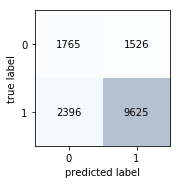

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# 精度確認
y_pred = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(cnf_matrix)
plt.show()

In [8]:
# モデルの評価指標
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()

# Recall（検出率）
recall = round(tp / (tp + fn), 3)
print("１．複勝馬の的中率："+str(recall))

# Precision（精度）
precision = round(tp / (tp + fp), 3)
print("２．購入馬券の的中率："+str(precision))

１．複勝馬の的中率：0.536
２．購入馬券の的中率：0.424


In [12]:
# モデルの保存
import pickle

model_name = "svc(kernel='rbf')"

p = Prediction()
p.label = model_name
p.bin = pickle.dumps(clf)
p.type = "classification"
p.recall = 0.536
p.precision = 0.424
p.note = "class_weight='balanced'"
p.save()

Prediction.objects.filter(label=model_name).values("label", "type", "recall", "precision", "note")

<QuerySet [{'label': "svc(kernel='rbf')", 'type': 'classification', 'recall': 0.536, 'precision': 0.424, 'note': "class_weight='balanced'"}]>